In [69]:
import pandas as pd
from pathlib import Path
import numpy as np
from collections import Counter
from time import time
from datetime import datetime, timedelta, time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show, output_file, output_notebook
from scipy.stats import normaltest

In [3]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('fivethirtyeight')

In [217]:
data_path = Path('/drive/data/algo_trading/data/itch')
itch_store = str(data_path / 'itch.h5')
stock_store = str(data_path / 'aapl.h5')
stock = 'AAPL'
date = '20180329'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

In [235]:
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code')
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

## Trade Summary

In [85]:
with pd.HDFStore(hdf_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8613 entries, 0 to 8612
Data columns (total 17 columns):
stock_locate                      8613 non-null int64
tracking_number                   8613 non-null int64
timestamp                         8613 non-null timedelta64[ns]
stock                             8613 non-null object
market_category                   8613 non-null object
financial_status_indicator        8613 non-null object
round_lot_size                    8613 non-null int64
round_lots_only                   8613 non-null object
issue_classification              8613 non-null object
issue_sub_type                    8613 non-null object
authenticity                      8613 non-null object
short_sale_threshold_indicator    8613 non-null object
ipo_flag                          8613 non-null object
luld_reference_price_tier         8613 non-null object
etp_flag                          8613 non-null object
etp_leverage_factor               8613 non-null int64
inverse_

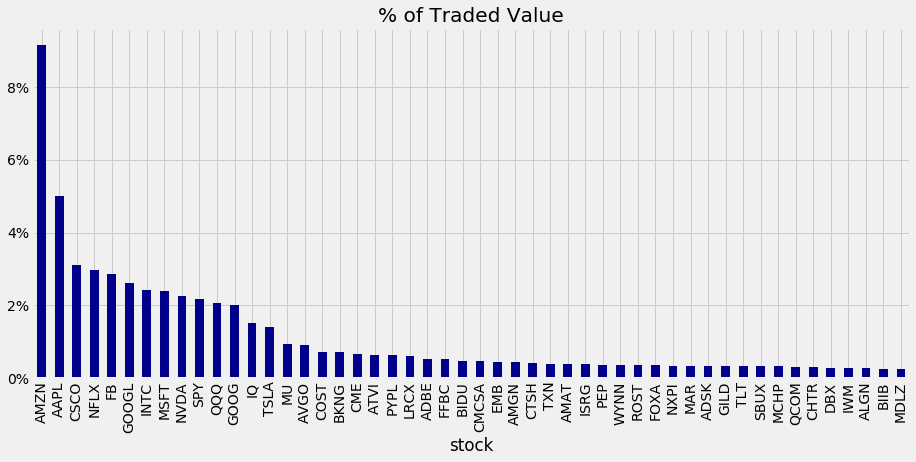

In [87]:
with pd.HDFStore(hdf_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## AAPL Trade Summary

In [267]:
with pd.HDFStore(stock_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66310 entries, 2018-03-29 09:30:00.001739838 to 2018-03-29 15:59:59.992118870
Data columns (total 2 columns):
shares    66310 non-null int64
price     66310 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


### Price-Volume Chart

In [239]:
def price_volume(df, price='vwap', vol='vol', suptitle=title):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

## Tick Bars

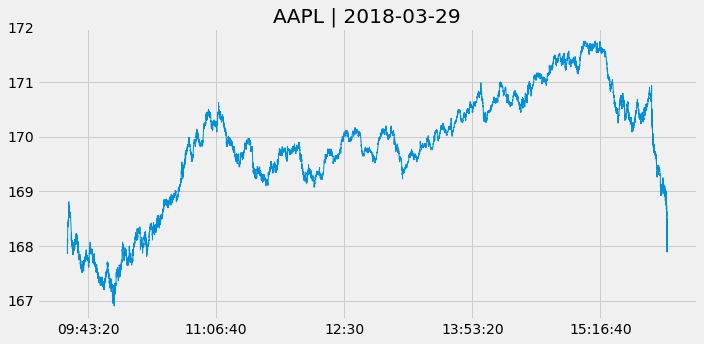

In [240]:
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(10, 5), title='{} | {}'.format(stock, pd.to_datetime(date).date()), lw=1)
plt.xlabel('')
plt.tight_layout();

In [191]:
from scipy.stats import normaltest
normaltest(tick_bars.price.pct_change().dropna())

NormaltestResult(statistic=62408.76562431228, pvalue=0.0)

## Time Bars

In [244]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)    

In [245]:
resampled = trades.resample('1Min')
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

NormaltestResult(statistic=46.28292467593722, pvalue=8.908213220616216e-11)

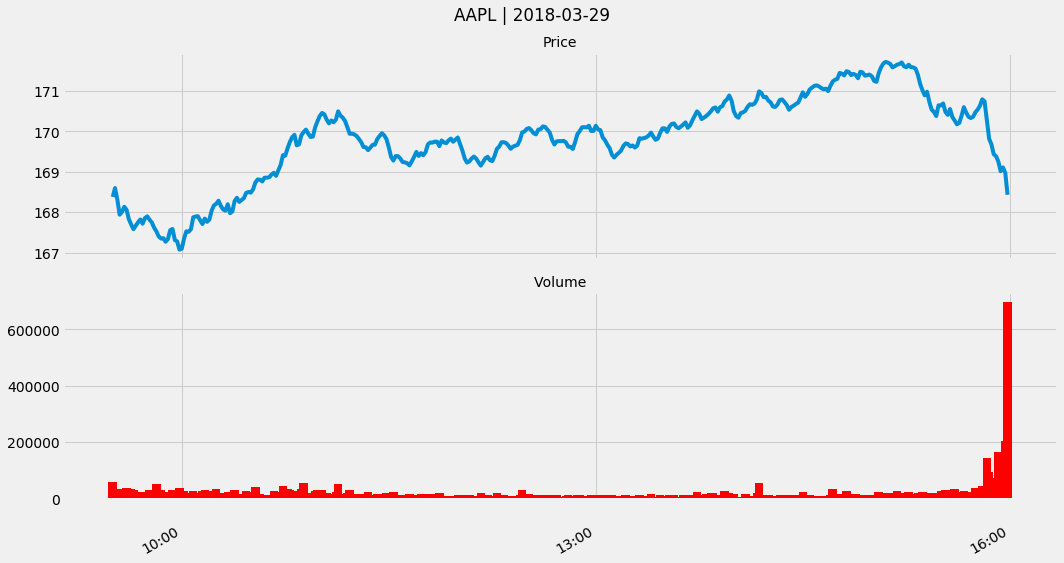

In [246]:
price_volume(time_bars)

### Candlestick Chart

In [249]:
resampled = trades.resample('5Min') # 5 Min bars for better print
df = get_bar_stats(resampled)

increase = df.close > df.open
decrease = df.open > df.close
w = 2.5 * 60 * 1000 # 2.5 min in ms

WIDGETS = "pan, wheel_zoom, box_zoom, reset, save"

p = figure(x_axis_type='datetime', tools=WIDGETS, plot_width=1500, title = "AAPL Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.4

p.segment(df.index, df.high, df.index, df.low, color="black")
p.vbar(df.index[increase], w, df.open[increase], df.close[increase], fill_color="#D5E1DD", line_color="black")
p.vbar(df.index[decrease], w, df.open[decrease], df.close[decrease], fill_color="#F2583E", line_color="black")
show(p)

![title](aapl_candlestick.png)

## Volume Bars

In [268]:
with pd.HDFStore(stock_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66310 entries, 2018-03-29 09:30:00.001739838 to 2018-03-29 15:59:59.992118870
Data columns (total 2 columns):
shares    66310 non-null int64
price     66310 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


In [269]:
trades_per_min = trades.shares.sum()/(60*7.5) # min per trading day
trades['cumul_vol'] = trades.shares.cumsum()

In [271]:
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
vol_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_vol,,,,,,,,
0,2018-03-29 09:30:02.368284509,168.03,168.13,167.86,168.04,168.03,8374,79
1,2018-03-29 09:30:26.215197872,168.04,168.44,168.03,168.36,168.27,17114,156
2,2018-03-29 09:30:46.370944389,168.36,168.50,168.35,168.50,168.40,17234,166
3,2018-03-29 09:31:01.381720009,168.50,168.81,168.50,168.64,168.67,17053,129
4,2018-03-29 09:31:29.495295771,168.64,168.74,168.52,168.54,168.61,16999,150


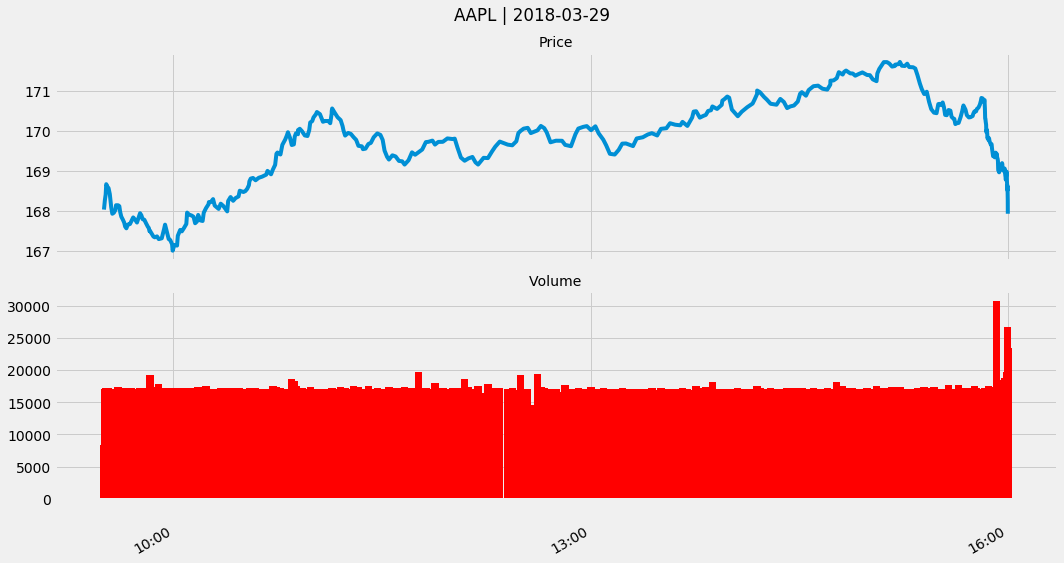

In [273]:
price_volume(vol_bars.set_index('timestamp'))

In [274]:
normaltest(vol_bars.vwap.dropna())

NormaltestResult(statistic=38.76411171464098, pvalue=3.823667266962872e-09)

In [216]:
trades.set_index('timestamp').between_time(time(9,30), time(16,0,1)).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66319 entries, 2018-03-29 09:30:00.001739838 to 2018-03-29 16:00:00.605858291
Data columns (total 3 columns):
shares    66319 non-null int64
price     66319 non-null float64
cross     66319 non-null int64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB


In [435]:
nseconds= 6.5 * 60 ** 2
grp_size = int(len(trading_day) / nseconds * 10)
grp_size

28

In [436]:
trading_day.groupby(trading_day.index.to_series().div(grp_size).astype(int)).size().head()

0    28
1    28
2    28
3    28
4    28
dtype: int64

In [438]:
trading_day['cumulative'] = trading_day.shares.cumsum()
trading_day.tail()

,timestamp,price,shares,cumulative
66339,2018-03-29 15:59:59.965047541,167.97,150,7696451
66340,2018-03-29 15:59:59.966533544,167.96,1300,7697751
66341,2018-03-29 15:59:59.966566710,167.89,1973,7699724
66342,2018-03-29 15:59:59.966710096,167.89,33,7699757
66343,2018-03-29 15:59:59.992118870,167.89,1256,7701013


In [448]:
trading_day.groupby(trading_day.cumulative.div(10000).astype(int)).agg({'price': 'last', })
trading_day.head()

,timestamp,price,shares,cumulative
0,2018-03-29 09:30:00.001739838,168.03,108,108
1,2018-03-29 09:30:00.100735299,168.03,200,308
2,2018-03-29 09:30:00.213004153,167.98,220,528
3,2018-03-29 09:30:00.427592679,167.86,6,534
4,2018-03-29 09:30:00.563613580,168.07,100,634


## Order Book Depth

In [119]:
with pd.HDFStore(stock_store) as store:
    buy = store['{}/buy'.format(stock)]
    sell = store['{}/sell'.format(stock)]

,price,shares
timestamp,,
2018-03-29 16:00:00,167.97,5947293
2018-03-29 15:59:00,167.89,696610
2018-03-29 09:30:00,168.72,370114
2018-03-29 15:58:00,168.88,205899
2018-03-29 15:55:00,169.00,166022


In [136]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

In [137]:
pd.concat([buy.price.describe(percentiles=[.01, .02, .98, .99]).to_frame('buy'), 
           sell.price.describe(percentiles=[.01, .02, .98, .99]).to_frame('sell')], axis=1)

,buy,sell
count,57606408.00,59907595.00
mean,169.59,179.06
std,1.88,1463.41
min,0.00,166.91
1%,166.52,167.05
2%,166.66,167.09
50%,169.82,168.41
98%,171.64,169.42
99%,171.69,169.58
max,171.74,199999.99


In [138]:
buy = buy[buy.price > buy.price.quantile(.1)]
sell = sell[sell.price < buy.price.quantile(.1)]

/home/stefan/.pyenv/versions/3.6.4/envs/at-3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


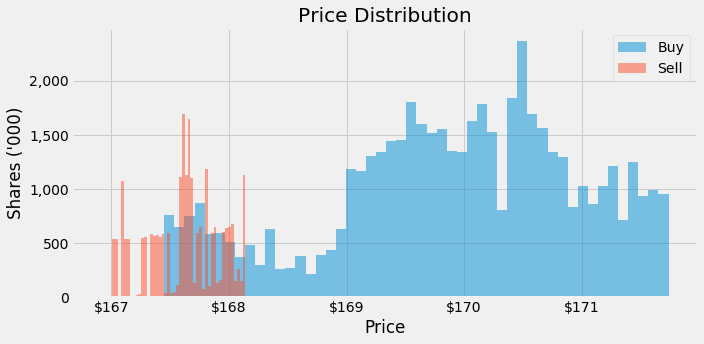

In [139]:
plt.figure(figsize=(10,5))
hist_kws = {'linewidth': 1, 'alpha': .5}
ax = sns.distplot(buy.price, label='Buy', kde=False, hist_kws=hist_kws)
ax = sns.distplot(sell.price, ax=ax, label='Sell', kde=False, hist_kws=hist_kws)
plt.legend()
plt.title('Price Distribution')
ax.set_yticklabels(['{:,}'.format(int(y/1000)) for y in ax.get_yticks().tolist()])
ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
plt.xlabel('Price')
plt.ylabel('Shares (\'000)')
plt.tight_layout();

In [140]:
buy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51818424 entries, 2018-03-29 14:13:05.000316928 to 2018-03-29 11:38:49.560053077
Data columns (total 2 columns):
price     float64
shares    int64
dtypes: float64(1), int64(1)
memory usage: 1.2 GB


In [141]:
buy = buy.set_index('price', append=True).unstack().loc[:, 'shares']
buy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 578326 entries, 2018-03-29 04:05:26.972972027 to 2018-03-29 20:00:00.080827773
Columns: 430 entries, 167.45000000000002 to 171.74
dtypes: float64(430)
memory usage: 1.9 GB


In [142]:
sell = sell.set_index('price', append=True).unstack().loc[:, 'shares']
sell.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 598500 entries, 2018-03-29 04:00:10.006734557 to 2018-03-29 20:00:00.080771914
Columns: 124 entries, 166.91 to 168.14000000000001
dtypes: float64(124)
memory usage: 570.8 MB


In [143]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67697 entries, 0 to 67698
Data columns (total 4 columns):
timestamp    67697 non-null datetime64[ns]
shares       67697 non-null int64
price        67697 non-null float64
cross        67697 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.6 MB


In [144]:
by_min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 957 entries, 2018-03-29 04:03:00 to 2018-03-29 19:59:00
Freq: T
Data columns (total 2 columns):
price     591 non-null float64
shares    957 non-null int64
dtypes: float64(1), int64(1)
memory usage: 62.4 KB


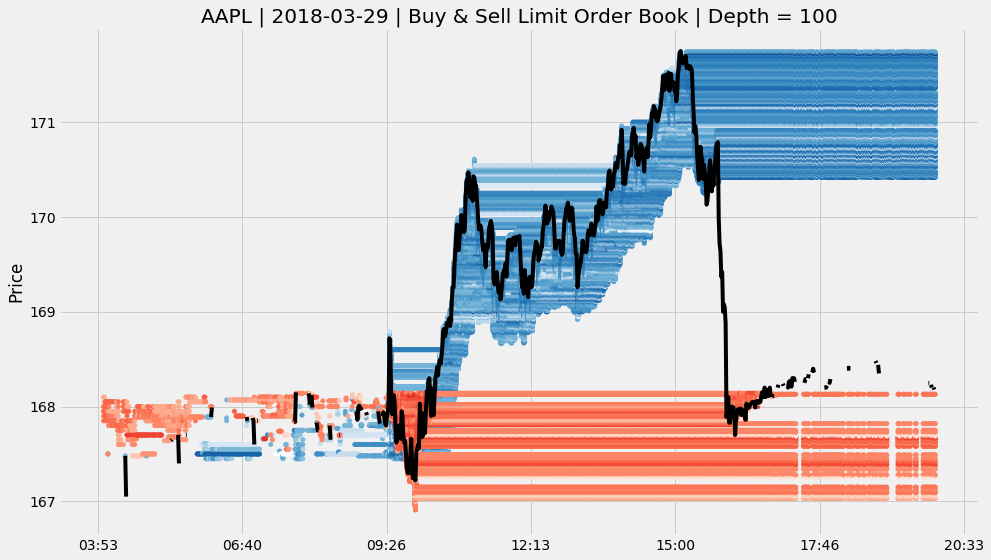

In [145]:
buy_min = buy.resample('1min').last()
buy_min = buy_min.stack().to_frame('shares').reset_index()
utc_offset = timedelta(hours=4)
buy_min.timestamp = buy_min.timestamp.add(utc_offset).astype(int)
buy_min.shares = np.log(buy_min.shares)
ax = buy_min.plot.scatter(x='timestamp',y='price', c='shares', figsize=(14, 8), colormap='Blues', colorbar=False)

trades_min = trades.set_index('timestamp').resample('1min')
trades_min = trades_min.agg({'price': 'last', 'shares': 'sum'}).reset_index()
trades_min.index = trades_min.timestamp.add(utc_offset).astype(int)
ax = trades_min.price.plot(figsize=(14, 8), c='k', ax=ax)

sell_min = sell.resample('1min').last()
sell_min = sell_min.stack().to_frame('shares').reset_index()
sell_min.shares = np.log(sell_min.shares)
sell_min.timestamp = sell_min.timestamp.add(utc_offset).astype(int)
ax = sell_min.plot.scatter(x='timestamp',y='price', c='shares', ax=ax, colormap='Reds', colorbar=False)

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

plt.xlabel('')
plt.ylabel('Price')
plt.title('AAPL | {} | Buy & Sell Limit Order Book | Depth = 100'.format(pd.to_datetime(date).date()))
plt.tight_layout()
plt.savefig('order_book', dpi=600);